# Задание

Решить задачу классификации рукописных цифр на датасете mnist https://www.kaggle.com/datasets/hojjatk/mnist-dataset. Правила следующие:
- нужно представить решение в виде нейронной сети, написанной на numpy, и обученной с помощью алгоритма градиентного спуска;
- нейронная сеть должна состоять из двух линейных слоев, активаций relu и softmax, и mse лосса;
- нельзя пользоваться автоградиентом (pytorch, numpy). Градиенты должны считаться вручную по алгоритму обратного распространения ошибки, используя аналитические формулы производных;
- решение считается валидным, если оно достигает аккураси больше 50%.

## Настройки/Гиперпараметры/Импорты

In [74]:
import matplotlib.pyplot as plt # для вывода графиков/картинок
import numpy as np # для работы с матрицами

import torchvision # для работы с картинками (преобразований)
import torch # для создания модели
# import cv2

In [17]:
device_id = -1 # номер девайса
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # если номер девайса >=0 - используем GPU

# Загрузка и обработка данных

In [19]:
# преобразования над датасетом
transforms = torchvision.transforms.Compose([ # Compose объединяет несколько преобразований вместе, чтобы они выполнялись "последовательно"
    torchvision.transforms.ToTensor(), # преобразование PIL изображения (или ndarray формата (Height x Width x Channels)) в tensor (типа float со значениями в области [0.0, 1.0], если такая трансформация поддерживается (см описание ToTensor))
    torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,)) # нормализация каналов (в датасете всего один канал) к указанным среднему значению и стандартному отклонению (цифры подобраны под датасет)
])

# датасет
data_train = torchvision.datasets.MNIST(root="./data", # путь, откуда брать/куда сохранять датасет
                                        train=True, # скачиание обучающей части датасета
                                        download=True, # скачивать ли датасет, если его нет в root пути
                                        transform=transforms # функция, принимающая на вход PIL Image и преобразовывающая его
                                       )

# загрузчик данных для обучения
train_loader = torch.utils.data.DataLoader(dataset=data_train, # указание датасета для DataLoader
                                           batch_size=10, # размер батчка (число сэмплов, что будет возвращать DataLoader за раз) (градиент усредняется по батчу, ускоряется обработка датасета, но слегка замедляется обработка сэмпла)
                                           num_workers=5, # число используемых ядер процессора для ускорения обработки данных
                                           pin_memory=True # нужно ли заранее аллоцировать память под объект на GPU (лучше так, чем возвращать CUDA tensors при multi-process loading)
                                          )

In [21]:
data_train # данные о датасете

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [23]:
data_train[0][0] # первое "изображение" датасета после применения трансформаций

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [22]:
data_train[0][1] # класс (target) первого изображения

5

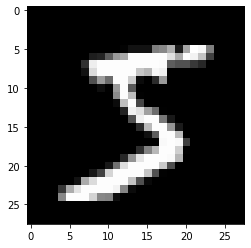

In [27]:
plt.imshow(data_train[0][0].reshape((28, 28, 1)), cmap='gray') # построение изображения
# .reshape((28, 28, 1)), так как shape(1, 28, 28) ~ (Channels, Height, Width) не воспринимается
# cmap='gray' так как изображение одноканальное, то есть чёрно-белое
plt.show() # вывод изображения

# Создание модели

## - ReLU

$$ 
ReLU(x) =  
\left\{
\begin{array}{ll}
      0 & if & x \leq 0 \\
      x & if & x > 0 \\
\end{array} 
\right.
$$

$$ 
\dfrac{dReLU(x)}{dx} =  
\left\{
\begin{array}{ll}
      0 & if & x \leq 0 \\
      1 & if & x > 0 \\
\end{array} 
\right.
$$

<center><img src="pics/ReLU.png"></center>

In [329]:
class ReLU():
    def __init__(self):
        """
        Конструктор ReLU функции.
        """
        self.prev_input = None # вход с предыдущего слоя
        # print("constructed")


    def forward(self, x: np.ndarray) -> np.ndarray: # numpy.array — это просто удобная функция для создания numpy.ndarray
        """
        Функция активации ReLU, если значение в X меньше или равно нулю - оно становится нулём, иначе — остаётся прежним.\n
        Parameters:
            * x: данные в виде массива размера (batch_size, features)\n
        Returns:
            * np.ndarray: преобразованный x согласно работе функции активации
        """
        self.prev_input = x.copy() # запоминаем вход с предыдущего шага
        x[x<0] = 0.0 # заменяем все значения в x, что меньше нуля на ноль
        return x
    

    def backward(self, grad):
        grad[self.prev_input < 0] = 0 # зануляем градиент там, где вход был меньше нуля
        return grad

## - Softmax

$$
Softmax(x_i) = \dfrac{e^{x_i}}{\sum_{j}e^{x_j}}
$$

In [330]:
class Softmax():
    def __init__(self):
        """
        Конструктор Softmax функции.
        """
        # print("constructed")

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Функция Softmax, пересчитывающая для всех элементов массива x значение e^x_i/summ(e^x_i).\n
        Parameters:
            * x: данные в виде массива размерности (batch_size, class_count) ~ (размер батча, число классов)\n
        Returns:
            * np.ndarray: преобразованный X согласно формуле Softmax
        """
        e = np.exp(x) # считаем экспоненту от всех элементов X (каждый элемент в X идёт как степень e)
        for batch in range(e.shape[0]): # идём по батчам
            e[batch] = e[batch] / e[batch].sum() # каждый элемент (экспоненту) в батче делим на сумму экспонент этого батча
        return e # возвращаем результат Softmax
    
    def backward(self, grad):
        return grad # просто возвращаем полученный градиент

## - Linear layer

$$
y = xW^T + b
$$
* x - вход размера (batch_size, in_features)
* W - вектора-строка весов, поэтому для умножения её транспонируют, получая вектор-столбец (in_features, out_features)
* b - вектор-строка для смещения размера (out_features)
* y - выход размера (batch_size, out_features)

In [347]:
class Linear: # линейный слой без смещения (bias)
    def __init__(self, in_features, out_features):
        """
        Конструктор линейного слоя.
        """
        # self.w = np.random.randn(28*28, 196)
        # self.bias = np.random.randn(196)

        self.in_features = in_features
        self.out_features = out_features

        self.prev_input = None # вход с предыдущего слоя
        self.w = np.random.randn(in_features, out_features)
        self.bias = np.random.randn(out_features) # смещение как вектор-строка
        # self.w = np.random.randn(out_features, in_feature)
        # self.bias = np.random.randn(out_features) # смещение как вектор-строка


    def forward(self, x):
        """
        Функция, применяющая веса и смещение к входным данным.\n
        """
        self.prev_input = x.copy() # запоминаем вход с предыдущего шага
        #========== v1
        # res = np.matmul(x, np.transpose(self.w)) # умножаем вход на веса
        #========== v2
        # res = np.matmul(self.w, X) # умножаем вход на веса
        #========== v3*
        res = np.matmul(x, self.w) # умножаем вход на веса (batch_size, in_features)x(in_features, out_features)=(batch_size, out_features)
        #========== v3.1
        # res = np.zeros(shape=(x.shape[0], self.out_features))
        # for batch in range(x.shape[0]):
        #     res[batch] = np.matmul(x[batch], w)
        #========== v3.2
        # res = np.zeros(shape=(x.shape[0], self.out_features))
        # for batch_id, batch in enumerate(x):
        #     res[batch_id] = np.matmul(batch, w)
        #==========

        #========== v1*
        # res = np.add(res, self.bias) # добавляем смещение (bias) для каждого батча
        #========== v1.1
        # for batch in res:
        #     batch += self.bias
        #==========
        return res
        
    
    def backward(self, grad: np.ndarray, lr: np.float64=0.01):
        """
        Функция, обновляющая веса слоя и передающая градиент дальше.\n
        """
        self.w = self.w - lr * grad.sum(axis=0)/grad.shape[0] # обновляем веса (усредняя градиент по батчам)
        # + делаем что-то со смещением


        print(grad.shape)
        print(self.prev_input.shape)
        # for batch in range(grad.shape[0]): # идём по батчам
        #     grad[batch] = 1/self.in_features * np.matmul(grad, self.prev_input)
        
        # grad = 1/self.in_features * np.matmul(grad, self.prev_input)

        return grad

### Linear testing

In [141]:
x = torch.randn(size=(10, 5))
w = torch.randn(size=(5, 3))
b = torch.randn(3)

In [163]:
res = np.zeros(shape=(10,3))
for batch in range(10):
    res[batch] = np.matmul(x[batch], w)
    res[batch] = np.add(res[batch], b)
res

array([[-1.2880511 , -0.73067941,  0.80104762],
       [-2.21654934,  1.70330536,  3.25667572],
       [-1.58797768, -1.10032916,  1.35084105],
       [-0.1923759 , -2.79034126,  3.99202061],
       [-4.31068921,  3.79309046, -3.91342926],
       [-1.30978702,  0.19246399,  4.02842474],
       [-2.10509318,  0.47696173,  1.13921094],
       [-1.01991095, -1.33258647, -3.6062541 ],
       [-4.42256474,  3.90015805, -6.54223108],
       [ 1.0639236 , -4.08856142,  0.51385152]])

In [161]:
l = Linear(5, 3)
l.w = w
l.bias = b
l.forward(x)

tensor([[-1.2881, -0.7307,  0.8010],
        [-2.2165,  1.7033,  3.2567],
        [-1.5880, -1.1003,  1.3508],
        [-0.1924, -2.7903,  3.9920],
        [-4.3107,  3.7931, -3.9134],
        [-1.3098,  0.1925,  4.0284],
        [-2.1051,  0.4770,  1.1392],
        [-1.0199, -1.3326, -3.6063],
        [-4.4226,  3.9002, -6.5422],
        [ 1.0639, -4.0886,  0.5139]], dtype=torch.float64)

In [146]:
res = np.matmul(x, w)
for batch in res:
    batch += b
res

tensor([[-1.2881, -0.7307,  0.8010],
        [-2.2165,  1.7033,  3.2567],
        [-1.5880, -1.1003,  1.3508],
        [-0.1924, -2.7903,  3.9920],
        [-4.3107,  3.7931, -3.9134],
        [-1.3098,  0.1925,  4.0284],
        [-2.1051,  0.4770,  1.1392],
        [-1.0199, -1.3326, -3.6063],
        [-4.4226,  3.9002, -6.5422],
        [ 1.0639, -4.0886,  0.5139]])

In [145]:
np.add(np.matmul(x, w), b)

tensor([[-1.2881, -0.7307,  0.8010],
        [-2.2165,  1.7033,  3.2567],
        [-1.5880, -1.1003,  1.3508],
        [-0.1924, -2.7903,  3.9920],
        [-4.3107,  3.7931, -3.9134],
        [-1.3098,  0.1925,  4.0284],
        [-2.1051,  0.4770,  1.1392],
        [-1.0199, -1.3326, -3.6063],
        [-4.4226,  3.9002, -6.5422],
        [ 1.0639, -4.0886,  0.5139]])

## - Model

In [348]:
class CustomNetwork():
    def __init__(self, in_features, out_features):
        # 196 = 784/4, то есть уменьшили в 4 раза
        self.linear1 = Linear(in_features, int(in_features/4)) # задаём первый линейный слой
        self.linear2 = Linear(int(in_features/4), 10) # задаём второй линейный слой
        self.activation = ReLU() # задаём активацию
        self.softmax = Softmax() # задаём softmax
        self.layers = [] # список всех слоёв модели
        self.layers.append(self.linear1)
        self.layers.append(self.linear2)
        self.layers.append(self.activation)
        self.layers.append(self.softmax)


    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Функция для вызова forward метода всех слоёв модели.\n
        Parameters:
            * x: данные на вход размера (batch_size, channels, height, width)\n
        Returns:
            * np.ndarray: результат вызова всех слоёв модели
        """
        x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]) # "избавляемся" от размерностей channels, height, width, совмещаем их в одномерный массив -> получаем двумерный массив размера (batch_size, channels*height*width)
        for layer in self.layers: # идём по слоям модели
            x = layer.forward(x) # последовательно вызываем forward метод каждого слоя
        return x
    

    def backward(self, grad) -> None:
        """
        Функция для обновления весов модели.\n
        Parameters:
            * grad: значение градиента, используемое для обновления весов\n
        Returns:
            * None: обновляет веса модели путём градиентного спуска
        """
        for layer in reversed(self.layers): # идём по слоям в обратном порядке
            grad = layer.backward(grad) # обновляем веса у слоя и возвращаем изменённый loss 


## - Cross-Entropy loss

$$
Cross Entropy Loss = - \dfrac{1}{batch\_size} \sum_{N=1}^{batch\_size} \sum_{C=1}^{classes}p^{true}_{N,C}*log_e(p^{pred}_{N,C})
$$

In [349]:
class CrossEntropyLoss:
    def __init__(self):
        """
        Конструктор функции для подсчёта CrossEntropyLoss.
        """
        self.loss = None # значение подсчитанного loss
        self.grad = None # градиент размера (batch_size, classes)
        self.p_pred = None
        self.p_true = None
    

    def calc_loss(self, p_pred, p_true) -> np.float64: # результат разниться с torch.nn.CrossEntropyLoss()!
        """
        Функция для подсчёта Cross-Entropy loss с усреднением по батчу.\n
        Parameters:
            * p_pred: предсказанные вероятности классов размера (batch_size, classes)
            * p_true: реальные вероятности классов размера (batch_size, classes)\n
        Returns:
            * np.float64: значение функции потерь
        """
        batch_size = p_true.shape[0] # размер батча
        classes = p_true.shape[1] # число классов
        loss = 0.0 # значение loss

        p_pred[p_pred==0.0] = 0.000001 # заменяем полностью нулевые вероятности на очень малые - чтобы логарифм в формуле не давал -inf

        for batch in range(batch_size): # идём по числу батчей (внешний цикл)
            #========== v1
            loss += np.matmul(p_true[batch], np.log(p_pred[batch])) # сумма по классам на определённом батче
            #========== v2
            # for c in range(classes):
            #     loss += p_true[batch][c] * np.log(p_pred[batch][c])
            #==========
        loss = - loss / batch_size # домножаем на -1 и берём среднее по батчам

        self.loss = loss # запоминаем подсчитанный loss
        #========== v1
        self.grad = np.zeros(shape=(batch_size, classes)) # заготовка под матрицу градиентов
        #========== v2
        # self.grad = np.zeros(shape=(1, classes)) # заготовка под матрицу градиентов (с усреднением по батчам)
        #==========
        self.p_pred = p_pred
        self.p_true = p_true
        return loss # возвращаем посчитанный loss
    

    def backward(self) -> np.ndarray:
        """
        Функция для подсчёта градиента после Cross-Entropy loss.\n
        Parameters:\n
        Returns:
            * np.ndarray: значение градиента размер (batch_size, classes)
        """
        #========== v1
        for batch in range(self.grad.shape[0]): # идём по номерам батчей
            for c in range(self.grad.shape[1]): # идём по классам
                self.grad[batch][c] = self.p_pred[batch][c] - self.p_true[batch][c] # считаем градиент (см grad.png)
        #========== v2
        # for batch in range(self.grad.shape[0]): # идём по номерам батчей
        #     for c in range(self.grad.shape[1]): # идём по классам
        #         self.grad[0][c] = self.p_pred[batch][c] - self.p_true[batch][c] # считаем градиент (см grad.png)
        # self.grad = self.grad / self.grad.shape[0] # усредняем градиент по числу батчей
        #==========
        return self.grad # возвращаем посчитанный градиент
        

### loss testing

In [280]:
l = CrossEntropyLoss()
l.calc_loss(np.array([[0.2,0.6,0.2]]),np.array([[1.0,0.0,0.0]]))

1.6094379124341003

In [281]:
l.backward()

array([[-0.8,  0.6,  0.2]])

In [282]:
probs_true = np.array([[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1], [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [1,0,0,0,1]], dtype=np.float64)
probs_true = torch.tensor(probs_true)
probs = np.random.randn(10, 5)
probs = Softmax.forward(probs)
probs = torch.tensor(probs)
probs

tensor([[0.0392, 0.2646, 0.2682, 0.0679, 0.3601],
        [0.2212, 0.3373, 0.0662, 0.0277, 0.3476],
        [0.1323, 0.0390, 0.0318, 0.0376, 0.7592],
        [0.1140, 0.0853, 0.0668, 0.0917, 0.6421],
        [0.0967, 0.1964, 0.2099, 0.3126, 0.1844],
        [0.4509, 0.3799, 0.0272, 0.0847, 0.0573],
        [0.2932, 0.0498, 0.1674, 0.4566, 0.0330],
        [0.1614, 0.5482, 0.1600, 0.1084, 0.0220],
        [0.2530, 0.0439, 0.3490, 0.2195, 0.1346],
        [0.1400, 0.3568, 0.0198, 0.2708, 0.2126]], dtype=torch.float64)

In [283]:
loss_torch = torch.nn.CrossEntropyLoss()
loss_torch(probs, probs_true)

tensor(1.8143, dtype=torch.float64)

In [284]:
l = CrossEntropyLoss()
l.calc_loss(probs, probs_true)

tensor(2.2514, dtype=torch.float64)

In [285]:
l.backward()

array([[-0.96084439,  0.26462033,  0.26824507,  0.06787287,  0.36010612]])

# Обучение модели

In [350]:
def train(model, train_loader, loss_func, num_classes): # функция обучения
    for batch_idx, (data, target) in enumerate(train_loader): # идём по батчам, что возвращает train_loader
        # переводим target в вероятностное пространство (везде нули, кроме нужного таргета - там единица)
        # p_true = np.array([0.0 if i != target else 1.0 for i in range(num_classes)], dtype=np.float64) # переводим target в вероятностное пространство (везде нули, кроме нужного таргета - там единица)
        p_true = np.zeros(shape=(train_loader.batch_size, num_classes)) # заготовка под вероятности (пока заполнена нулями)
        for batch, t in enumerate(target): # идём по батчу (нескольких сэмплам)
            p_true[batch][t] = 1.0 # ставим вероятность 1 у нужных таргетов (для всех элементов в батче)

        data=data.numpy() # переводим данные из формата tensor в numpy.array

        p_preds = model.forward(data) # вызываем forward pass модели (предсказываем)
        loss = loss_func.calc_loss(p_preds, p_true) # считаем loss модели
        grad = loss_func.backward() # считаем градиент ошибки
        model.backward(grad) # обновляем веса модели

In [351]:
num_classes = 10 # число классов (различных цифр)
model = CustomNetwork(in_features=np.prod(data_train[0][0].shape), out_features=num_classes) # np.prod(data_train[0][0].shape) - произведение всех размерностей входных данных
loss_func = CrossEntropyLoss()
train(model=model, train_loader=train_loader, loss_func=loss_func, num_classes=num_classes)
# loss - кросс-энтропия (перекрёстная энтропия)
# CrossEntropyLoss на вход ожидает вероятность класса для всех k классов
# то есть массив с вероятностями для каждой из четырёх категорий новостей

C:\Users\User\Documents\TEMP\ipykernel_38980\3543284042.py:16: RuntimeWarning: overflow encountered in exp
  e = np.exp(x) # считаем экспоненту от всех элементов X (каждый элемент в X идёт как степень e)
C:\Users\User\Documents\TEMP\ipykernel_38980\3543284042.py:18: RuntimeWarning: invalid value encountered in divide
  e[batch] = e[batch] / e[batch].sum() # каждый элемент (экспоненту) в батче делим на сумму экспонент этого батча


(10, 10)
(10, 196)


ValueError: operands could not be broadcast together with shapes (784,196) (10,) 

In [ ]:
state_dict = model.state_dict()
state_dict.keys()

In [ ]:
state_dict[]

In [ ]:
criterion = CrossEntropyLoss() # определяем функцию потерь — бинарную кросс-энтропию (хорошо для задачи бинарной классификации, где таргет может принимать лишь два значения - 0 и 1)
# При бинарной классификации каждая предсказанная вероятность сравнивается с фактическим значением класса (0 или 1), 
# и вычисляется оценка, которая штрафует вероятность на основе расстояния от ожидаемого значения.

# BCELoss выше, чем MSEloss примерно раза в 4 (на выбранном датасете), поэтому значение в 0.4 для BCE — это хорошо
model_log = CustomNetwork(X_train.shape[1], Y_train.shape[1]).to(torch.float64) # создаём объект модели

optimizer_1 = optim.Adam(model_log.parameters(), lr=learning_rate) # определяем оптимайзер — Adam и передаём в него веса модели с lr

for epoch in range(num_epochs): # проводим обучение и тестирование num_epochs раз
    Y_pred = model_log(X_train) # делаем предсказание
    loss = criterion(Y_pred, Y_train) # считаем ошибку по BCE loss

    losses["LogisticRegression"]["train"].append(loss.data) # запоминаем значение BCEloss

    optimizer_1.zero_grad() # обнуляем градиенты во всех обучаемых torch.Tensor (ставит w.grad = 0 в torch.Tensor с requires_grad=True) (вызывается перед loss.backward(), чтобы не аккумулировать градиенты за несколько итераций обучения)
    loss.backward() # считаем dloss/dw для каждого веса модели w, у которого requires_grad=True (сохраняется в w.grad следующим образом w.grad += dloss/dw)
    optimizer_1.step() # обновляет веса модели (тензоры, у которых стоит флаг requires_grad=True, используя значение из w.grad следующим образом w += -lr * w.grad)

    with torch.no_grad(): # запускаем валидацию (каждую эпоху)
        Y_pred = model_log(X_test) # вызываем forward с передачей X_test
        losses["LogisticRegression"]["test"].append(criterion(Y_pred, Y_test).data) # запоминаем значение BCEloss
plt.figure(figsize=(10,8)) # задание размера графика
plt.plot(losses["LogisticRegression"]["train"], "b", label='train') # построение BCE loss на обучении
plt.plot(losses["LogisticRegression"]["test"], "r", label='test') # построение BCE loss на тестировании

plt.title('BCE Loss with LogisticRegression') # название графика
plt.xlabel('epoch') # подпись по оси x
plt.ylabel('loss') # подпись по оси y
plt.legend() # вывод названий графиков
plt.show() # вывод графика

Всякие тесты

In [117]:
linear = torch.nn.Linear(10,100,bias = True)
linear.weight.shape

torch.Size([100, 10])